# Evaluation model on CIFAR_10

___

In [19]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10  # https://www.cs.toronto.edu/~kriz/cifar.html
import matplotlib.pyplot as plt
from torch.optim import Adam
from typing import Tuple, List
%matplotlib inline

___

### Realize nessesary functions

In [20]:
# Normalization function. Return mean and standard deviation
def get_normalize(features: torch.Tensor):
    # size [N, C, H, W]
    # N is amount of objects, C — amount of chanel, H, W — size of image
    # return mean by chanel and standard deviation by chanel

    means = features.mean(dim=(0, 2, 3))
    stds = features.std(dim=(0, 2, 3))

    return means, stds

In [21]:
# Function for augmentation.
# Resize image,  make augmentation for train (crop, b&w, blur, random)
# Make tensor from train and test and normalize
def get_augmentations(train: bool = True) -> T.Compose:
#     means = (dataset_train.data / 255).mean(axis=(0, 1, 2))
#     stds = (dataset_train.data / 255).std(axis=(0, 1, 2))
    means = (0.49139968, 0.48215841, 0.44653091)
    stds = (0.24703223, 0.24348513, 0.26158784)

    if train:
        return T.Compose([
            T.RandAugment(),
            T.ToTensor(),
            T.Normalize(mean=means, std=stds)
        ]
        )
    else:
        return T.Compose([
            T.ToTensor(),
            T.Normalize(mean=means, std=stds)
        ]
        )

In [22]:
@torch.inference_mode()
def predict(model: nn.Module, loader: DataLoader, device: torch.device):
    predictions = []
    model = model.to(device)
    model.eval()  # set the model to evaluation mode

    with torch.no_grad():  # deactivate autograd
        for x, _ in loader:  # we do not need 'y' for predictions
            x = x.to(device)
            output = model(x)  # forward pass
            preds = output.argmax(dim=1)  # get the predicted classes
            predictions.append(preds)

    return torch.cat(predictions)

In [23]:
@torch.inference_mode()
def predict_tta(model: nn.Module,
                loader: DataLoader,
                device: torch.device,
                iterations: int = 2):
    predictions = []
    model = model.to(device)
    model.eval()  # set the model to evaluation mode

    for i in range(iterations):
        single_prediction = []
        for x, _ in loader:
            x = x.to(device)
            output = model(x)  # forward pass
            single_prediction.append(output)

        predictions.append(torch.vstack(single_prediction))

    conc = torch.stack(predictions)

    mean = conc.mean(0)

    mean_preds = mean.argmax(dim=1)

    return mean_preds

In [24]:
from tqdm import tqdm


def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()
        
        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [25]:
#!g1.1
@torch.inference_mode()
def evaluate(model, loader) -> Tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [26]:
from IPython.display import clear_output

def plot_stats(
    train_loss: List[float],
    valid_loss: List[float],
    train_accuracy: List[float],
    valid_accuracy: List[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [27]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )
        
        print(f'Accuracy on {epoch + 1} epoch = {valid_accuracy}')
        
#         if valid_accuracy >= 0.88: 
#             print("Reached 88% accuracy on validation set. Stopping training.")
#             break
            
    print(f'Final accuracy = {valid_accuracy}')

___

### Load dataset

In [28]:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

In [29]:
train_dataset = CIFAR10('/kaggle/input/cifar10-input/cifar_10/', train=True)
valid_dataset = CIFAR10('/kaggle/input/cifar10-input/cifar_10/', train=False)

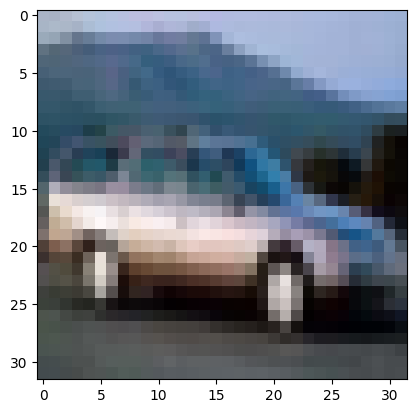

In [30]:
plt.imshow(train_dataset[4][0])
plt.show()

____

### Model Evaluation

In [31]:
train_dataset.data.shape

(50000, 32, 32, 3)

In [32]:
class create_simple_conv_cifar(nn.Module):
    def __init__(self):
        super(create_simple_conv_cifar, self).__init__()
        # we have 32 * 32 * 3 after resizing
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # 32 x 32 x 32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),  # 32 x 32 x 32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.MaxPool2d(2),  # 16 x 16 x 32
            nn.Dropout2d(p=0.25),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # 16 x 16 x 64
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),  # 16 x 16 x 64
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.MaxPool2d(2),  # 8 x 8 x 64
            nn.Dropout2d(p=0.25),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # 8 x 8 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),  # 8 x 8 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 4 x 4 x 128
            nn.Dropout2d(p=0.25),

            nn.Flatten(),

            nn.Linear(4 * 4 * 128, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.net(x)

In [33]:
train_dataset = CIFAR10('/kaggle/input/cifar10-input/cifar_10/', train=True, transform=get_augmentations())
valid_dataset = CIFAR10('/kaggle/input/cifar10-input/cifar_10/', train=False, transform=get_augmentations(train=False))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

In [34]:
train_dataset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [35]:
train_dataset.data.shape

(50000, 32, 32, 3)

In [36]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss_fn = nn.CrossEntropyLoss()
print(device)

cpu


In [37]:
model = create_simple_conv_cifar().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

In [38]:
for param in model.parameters():
    print(param.shape)

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([512, 2048])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([10, 512])
torch.Size([10])


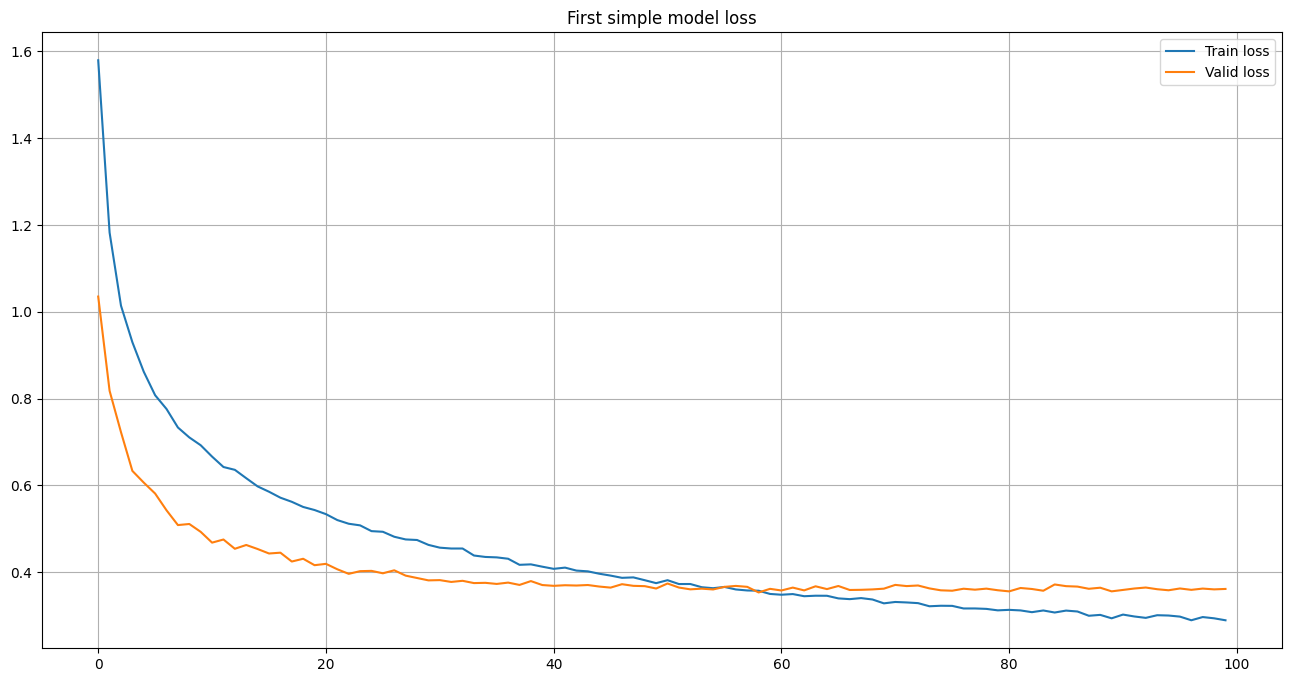

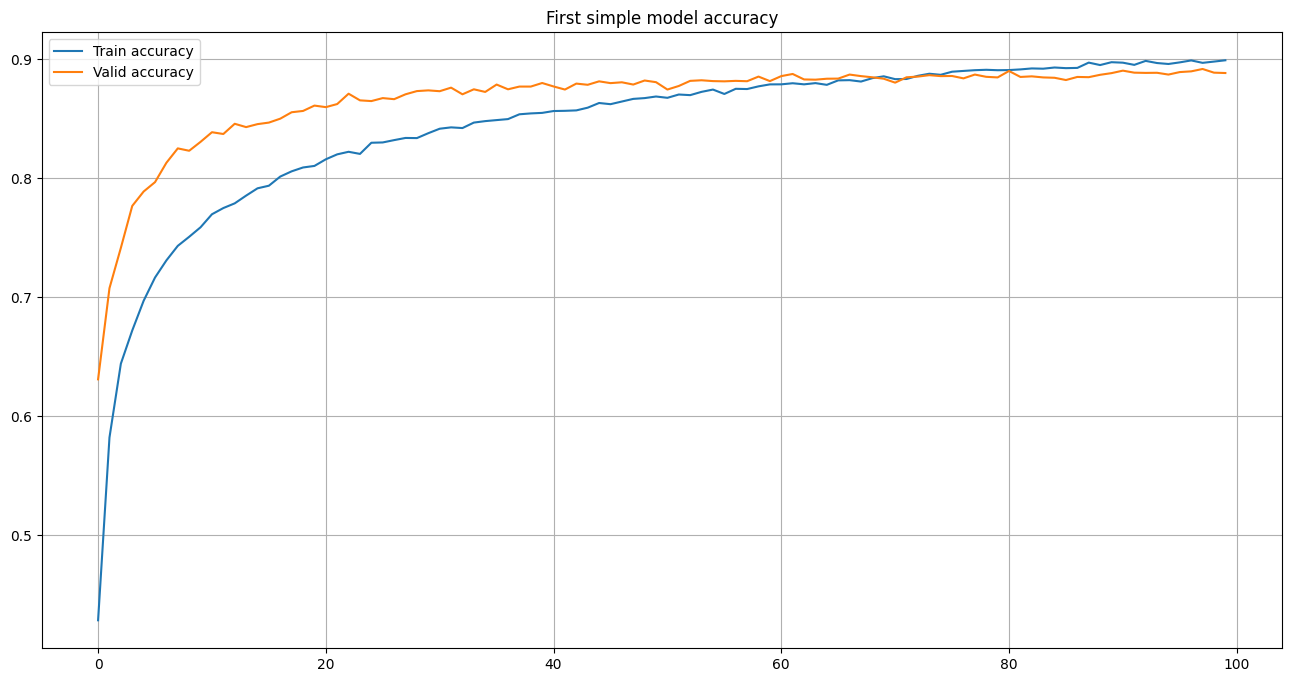

Accuracy on 100 epoch = 0.8886
Final accuracy = 0.8886


In [39]:
whole_train_valid_cycle(model, 100, 'First simple model')

In [40]:
predictions = predict(model, valid_loader, device)

In [41]:
torch.save(predictions, 'predictions.pt')

In [42]:
valid_for_predict = CIFAR10('/kaggle/input/cifar10-input/cifar_10/', train=False, transform=get_augmentations())
valid_loader_for_predict = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

In [43]:
predictions_tta = predict_tta(model, valid_loader, device)

In [44]:
predictions

tensor([3, 8, 8,  ..., 5, 1, 7])

In [45]:
predictions_tta

tensor([3, 8, 8,  ..., 5, 1, 7])

In [46]:
predictions_tta = predict_tta(model, valid_loader_for_predict, device)

In [ ]:
torch.save(predictions_tta, 'predictions_tta.pt')

____